# Data Overview

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from main import get_data, export_data
import os
from get_average_sentiment import load_mean_count
(root, data_path, presidents, cities, countries, years, colors) = get_data()

In [2]:
mean_compound = pd.read_pickle('results/mean_compound.pkl')

In [3]:
mean_compound

,Birmingham,LA,London,NYC,Great Britain,US,Total
trump,0.000941,-0.061045,0.026475,-0.049612,0.022986,-0.05551,-0.046108
johnson,0.054013,0.184652,0.026248,0.164726,0.031557,0.174949,0.061519
All,0.239253,0.156903,0.228856,0.143292,0.230849,0.150487,0.176390


In [4]:
total_count_path = f'results/total_count.pkl'
if os.path.exists(total_count_path):
    total_count = pd.read_pickle(total_count_path)
else:
    total_count = pd.DataFrame(index=[presidents[0], presidents[1], 'President Total', 'All'], columns=(cities + countries + ['Total']))
    for city in cities:
        total_count.at['All', city] = int(load_mean_count(f'{city}_mean_count', 'total_count'))

        city_trump = pd.read_pickle(f'{data_path}/trump-{city}.pkl')
        city_johnson = pd.read_pickle(f'{data_path}/johnson-{city}.pkl')
        total_count.at[presidents[0], city] = city_trump.shape[0]
        total_count.at[presidents[1], city] = city_johnson.shape[0]

    for row in total_count.index:
        total_count.at[row, countries[0]] = total_count.at[row, 'Birmingham'] + total_count.at[row, 'London']
        total_count.at[row, countries[1]] = total_count.at[row, 'LA'] + total_count.at[row, 'NYC']

    trump = pd.read_pickle(f'{data_path}/trump.pkl')
    johnson = pd.read_pickle(f'{data_path}/johnson.pkl')
    total_count.at[presidents[0], 'Total'] = trump.shape[0]
    total_count.at[presidents[1], 'Total'] = johnson.shape[0]

    for col in total_count.columns:
        total_count.at['President Total', col] = total_count.at[presidents[0], col] + total_count.at[presidents[1], col]

    total_count.at['All', 'Total'] = total_count.at['All', countries[0]] + total_count.at['All', countries[1]]
    export_data(total_count, f'results/total_count')
total_count

,Birmingham,LA,London,NYC,Great Britain,US,Total
trump,26758,742399,169071,696803,195829,1439202,1635031
johnson,50952,45289,223714,41560,274666,86849,361515
President Total,77710,787688,392785,738363,470495,1526051,1996546
All,7148908,41449103,30145037,36959351,37293945,78408454,115702399


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_compound(data, filename=None, colors=colors, bar_width=0.35):
    # Calculate the number of groups and the total number of bars in each group
    n_groups = data.shape[1]
    n_bars = data.shape[0]

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 5))

    # Set up the seaborn style for nicer plots
    sns.set(style="whitegrid")

    # Calculate the width of the entire group of bars
    group_width = bar_width * n_bars

    # Set the positions of the bars
    index = np.arange(n_groups) * (group_width + bar_width)  # Space out the groups
    bar_positions = [index + (bar_width * i) for i in range(n_bars)]

    # Plot bars for each president
    for i, president in enumerate(data.index):
        ax.bar(bar_positions[i], data.loc[president], bar_width, label=president.capitalize(), color=colors[i])

    # Set the position of the x ticks and labels to be in the middle of the group
    ax.set_xticks(index + group_width / 2 - bar_width / 2)
    ax.set_xticklabels(data.columns)
    # Set the labels and title
    ax.set_xlabel('Location')
    ax.set_ylabel('Mean Compound Sentiment')
    ax.set_title(filename)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    if filename:
        plt.savefig(f'visualizations/compound_sentiment/{filename}.png', format='png', bbox_inches='tight')
    plt.show()

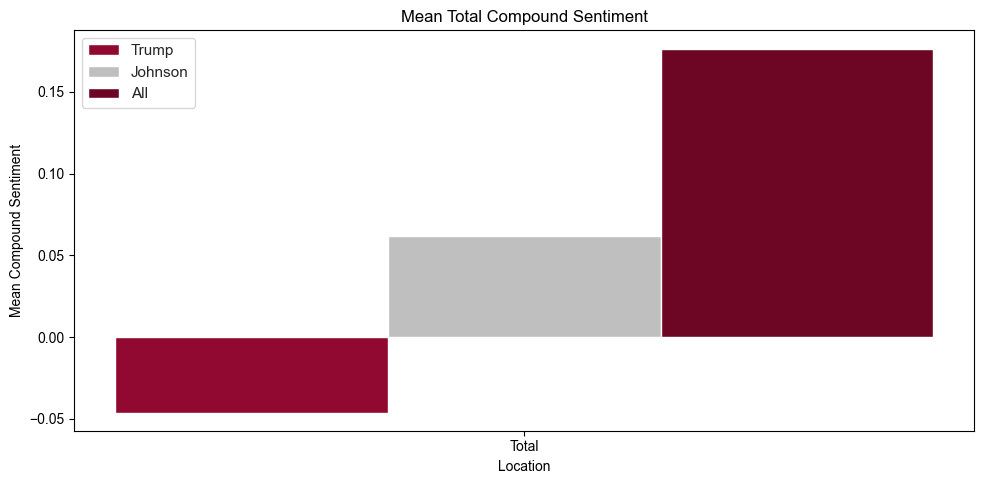

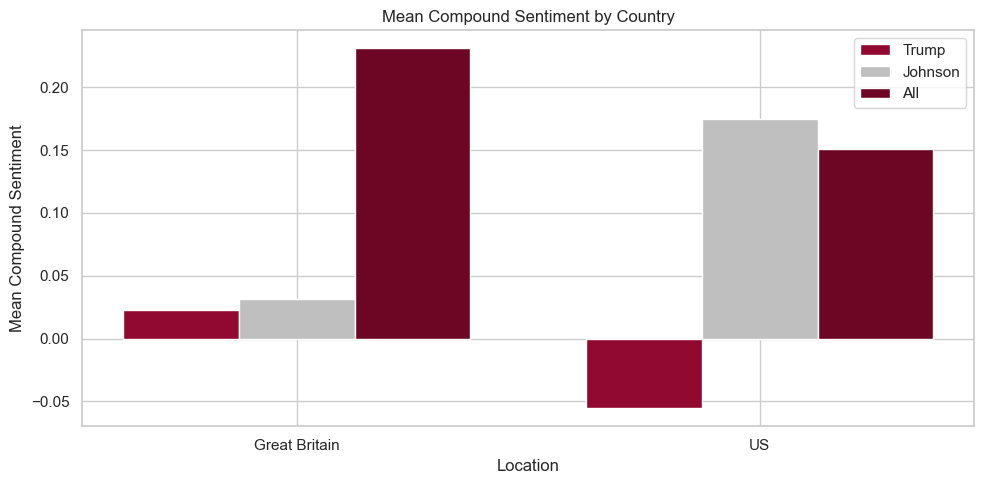

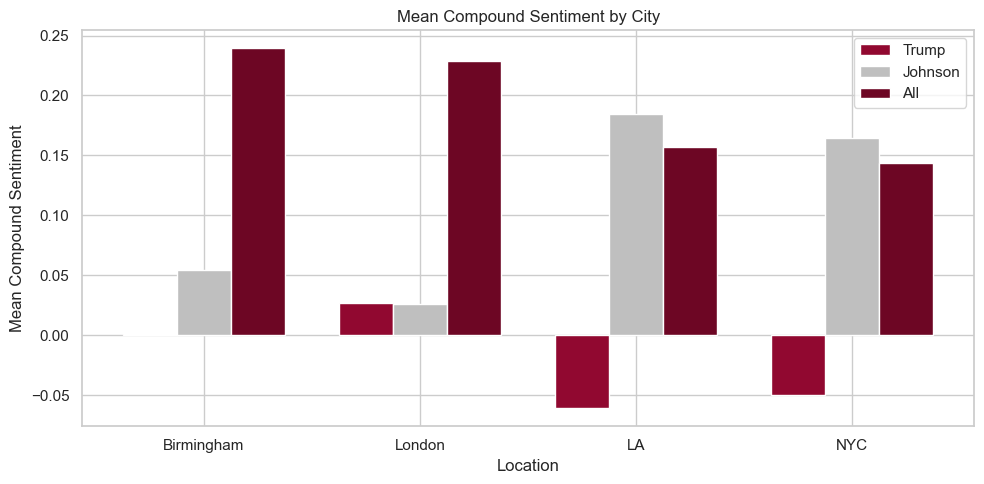

In [6]:
plot_mean_compound(mean_compound[mean_compound.columns[-1:]], filename=f'Mean Total Compound Sentiment')
plot_mean_compound(mean_compound[mean_compound.columns[-3:-1]], filename=f'Mean Compound Sentiment by Country')
plot_mean_compound(mean_compound[[cities[i] for i in [0, 2, 1, 3]]], filename=f'Mean Compound Sentiment by City')

### Variance

In [7]:
# todo calculate variation of each country/city
def get_variance(data):
    return np.var(data.T)

In [8]:
variance_path = f'results/variance'
if os.path.exists(total_count_path):
    variance = pd.read_pickle(total_count_path)
else:
    variance = pd.DataFrame(index=presidents, columns=cities  + countries+ ['Total'])
    for president in presidents:
        for location in cities + countries:
            location_data = pd.read_pickle(f'{data_path}{president}-{location}.pkl')
            variance.at[president, location] = get_variance(location_data['Compound'])

        president_data = pd.read_pickle(f'{data_path}{president}.pkl')
        variance.at[president, 'Total'] = get_variance(president_data['Compound'])

    export_data(total_count, variance_path)
    
variance

,Birmingham,LA,London,NYC,Great Britain,US,Total
trump,26758,742399,169071,696803,195829,1439202,1635031
johnson,50952,45289,223714,41560,274666,86849,361515
President Total,77710,787688,392785,738363,470495,1526051,1996546
All,7148908,41449103,30145037,36959351,37293945,78408454,115702399


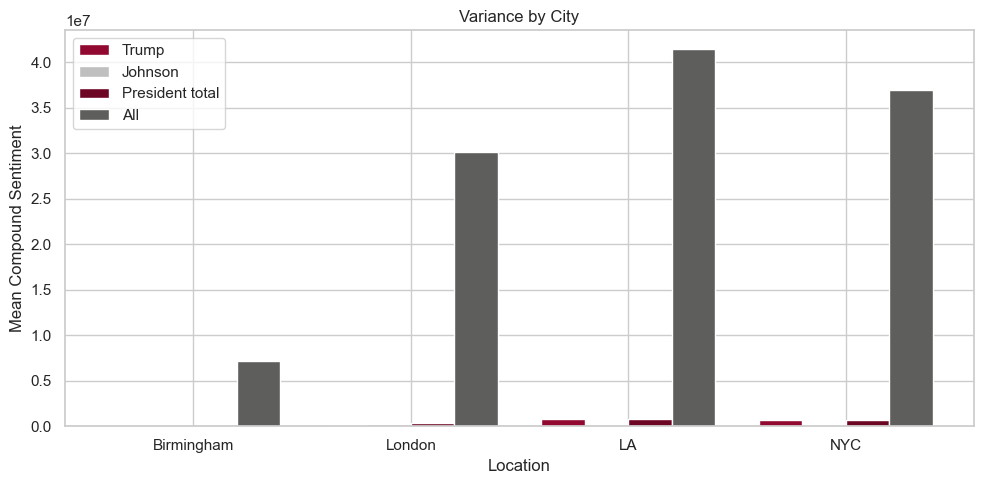

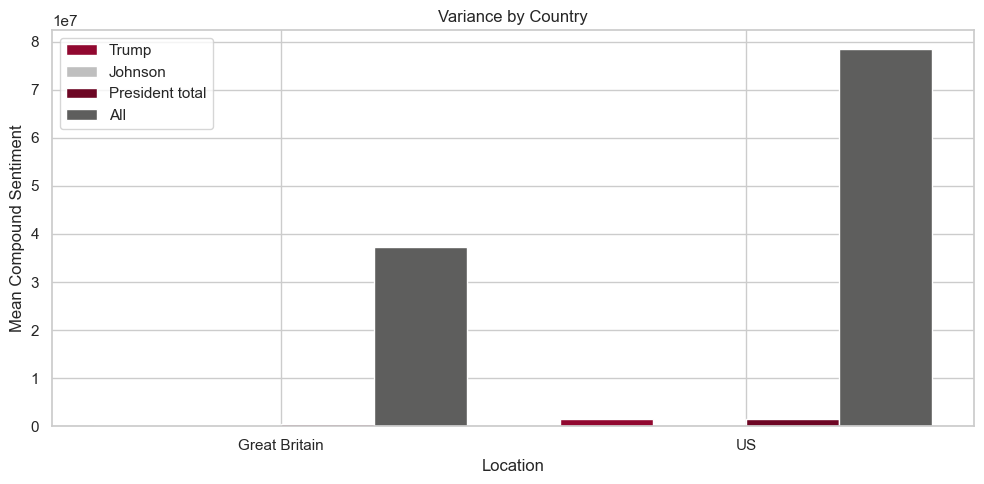

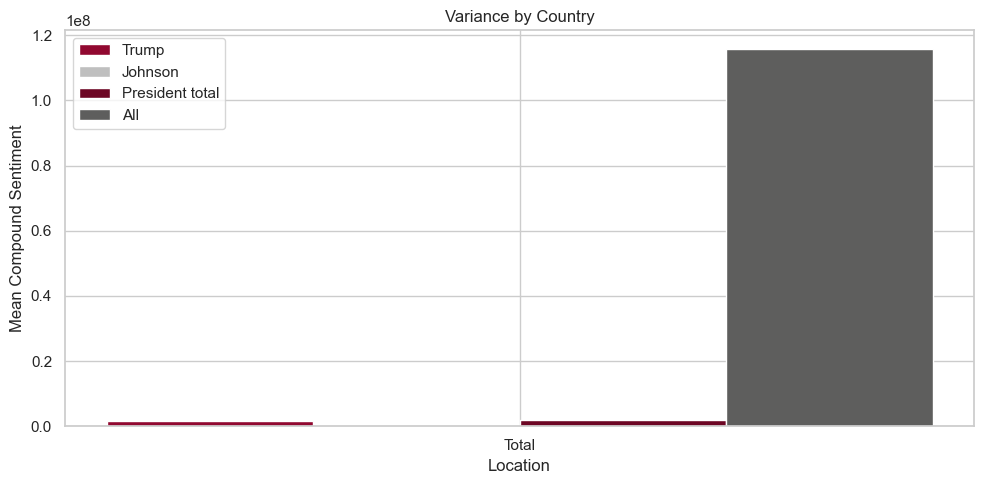

In [9]:
plot_mean_compound(variance[['Birmingham', 'London', 'LA', 'NYC']], filename="Variance by City")

plot_mean_compound(variance[['Great Britain', 'US']], filename="Variance by Country")

plot_mean_compound(variance[['Total']], filename="Variance by Country")

In [10]:
# TODO: check trump variance. Doesn't he have a lower variance than Johnson in the US?